取得 台指期 與小外資 投信連線

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=1000)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 可自由調整select的區間
# today_str = '20240813'
today_str = '20241231'
one_year_ago_str = '20210101'

# SQL 查詢 加權指數
query_daily_tx = f"""
SELECT *
FROM daily_tx
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_tif_investors = f"""
SELECT *
FROM daily_tif_investors
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tif_investors_df_raw = pd.read_sql(query_tif_investors, engine)
# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tx_df_raw = pd.read_sql(query_daily_tx, engine)

In [3]:
tif_investors_df_raw
# 五大特定淨部位
top5_sp = tif_investors_df_raw['買方前五大交易人合計'] - tif_investors_df_raw['賣方前五大交易人合計']
# 大外資 = 五大減投信 (投信應該依定會進去前五大)
big_foreign = top5_sp - tif_investors_df_raw['投信未平倉餘額口數']
# 小外資
small_foreign = tif_investors_df_raw['外資未平倉餘額口數'] - big_foreign

tif_investors_df_raw['大外資']  = big_foreign
tif_investors_df_raw['小外資']  = small_foreign



# 将 'Date' 列转换为 datetime 类型
tif_investors_df_raw['Date'] = pd.to_datetime(tif_investors_df_raw['Date'])
tx_df_raw['Date'] = pd.to_datetime(tx_df_raw['Date'])  # 假设你有一个 Date 列


tx_df_raw.loc[:, '5MA'] = tx_df_raw['最後成交價'].rolling(5).mean()
tx_df_raw.loc[:, '8MA'] = tx_df_raw['最後成交價'].rolling(8).mean()
tx_df_raw.loc[:, '10MA'] = tx_df_raw['最後成交價'].rolling(10).mean()
tx_df_raw.loc[:, '20MA']= tx_df_raw['最後成交價'].rolling(20).mean()
tx_df_raw.loc[:, '60MA']= tx_df_raw['最後成交價'].rolling(60).mean()
tx_df_raw.loc[:, '240MA']= tx_df_raw['最後成交價'].rolling(240).mean()

tx_df_raw = tx_df_raw.fillna(0)


畫畫前準備 設定INDEX (不可重複設定)

In [11]:
# 畫畫前準備資料
# 將欄位名稱改為 'Open', 'High', 'Low', 'Close'
tx_df_forplot = tx_df_raw.copy()
tif_investors_forplot = tif_investors_df_raw.copy()
tx_df_forplot.rename(columns={'開盤價': 'Open', '最高價': 'High', '最低價': 'Low', '最後成交價': 'Close'}, inplace=True)
tx_df_forplot.set_index('Date', inplace=True)
tif_investors_forplot.set_index('Date', inplace=True)

可透過 plot_size 調整繪畫的尺度 (單位:天數)

In [9]:
# 畫畫要畫幾天的資料
plot_size = 100

大外資

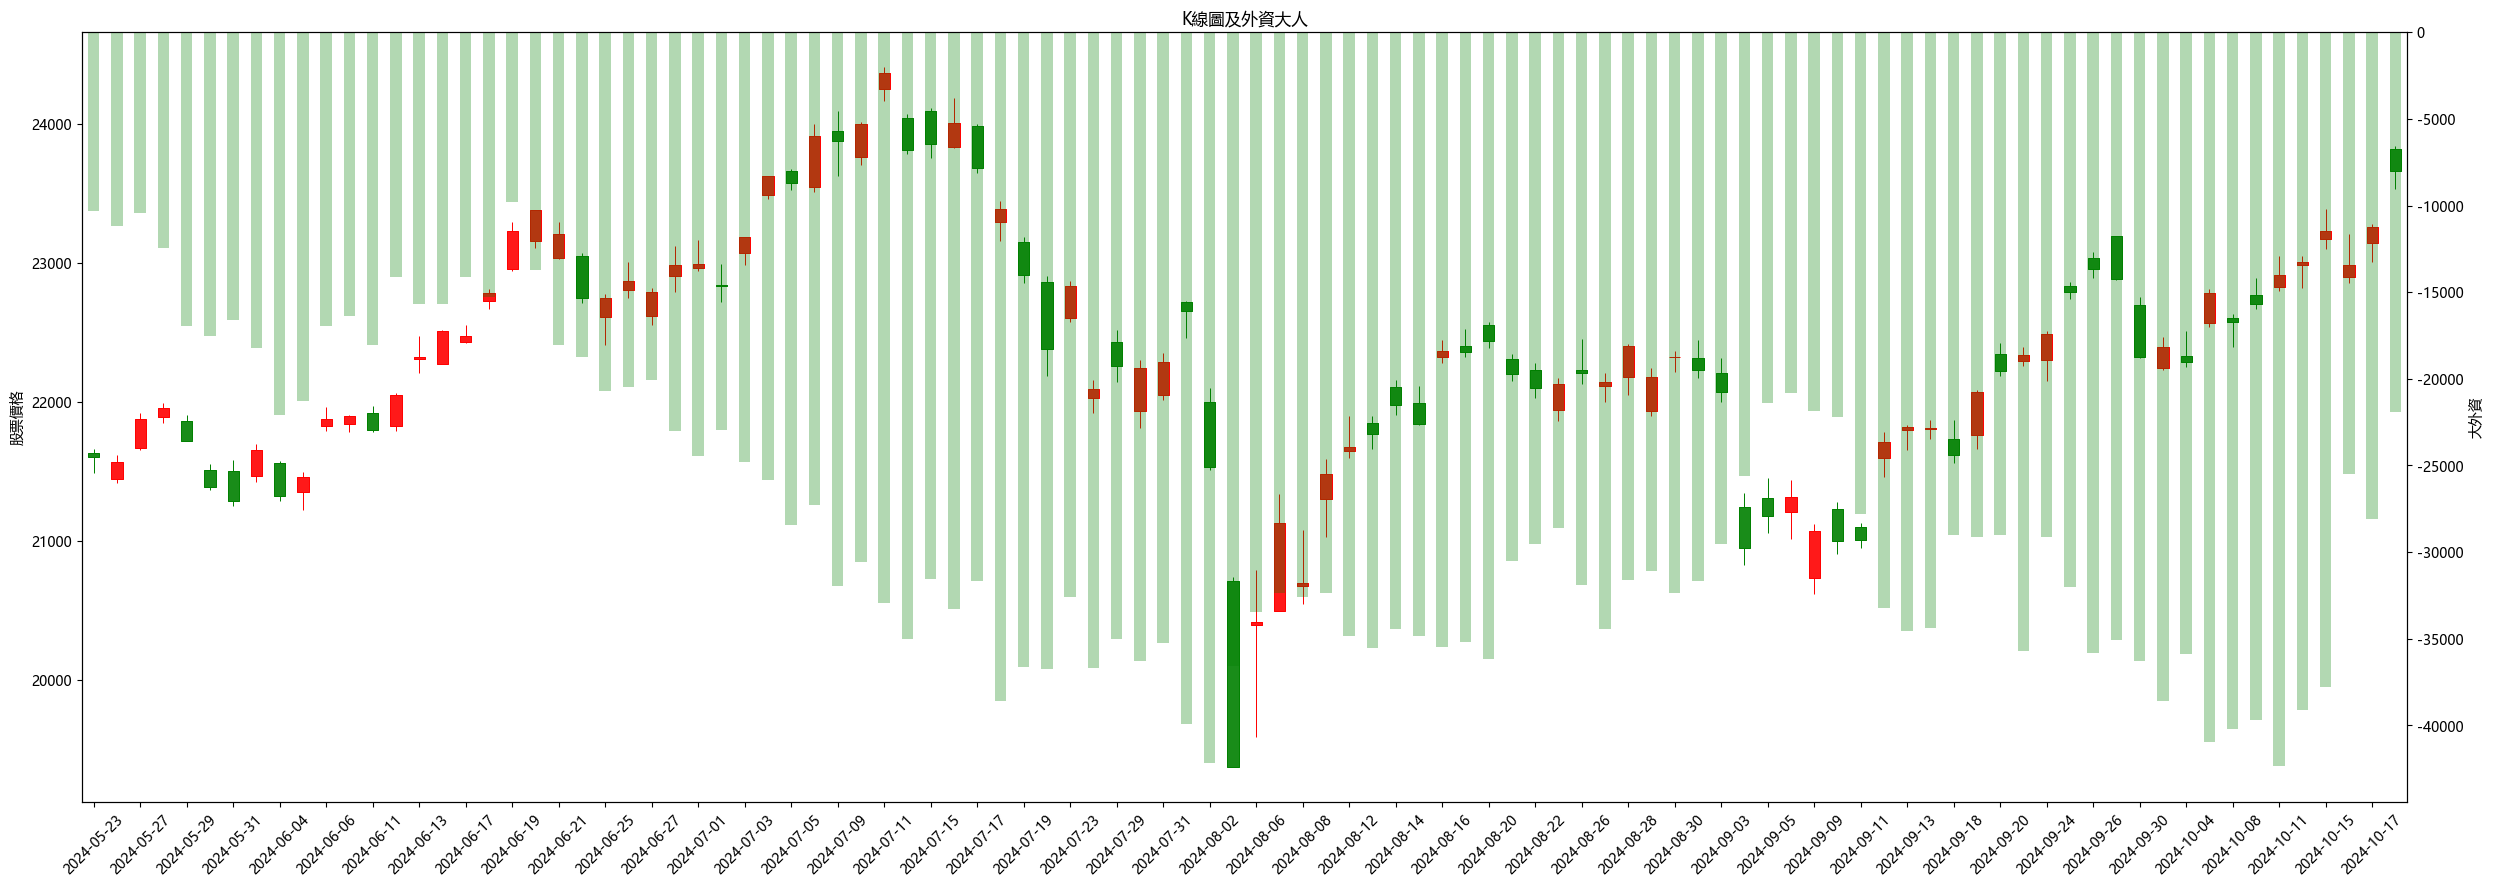

In [78]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


tx_df_raw_100 = tx_df_forplot.tail(plot_size)
tif_investors_df_raw_100 = tif_investors_forplot.tail(plot_size)
tif_investors_df_raw_100.index = tif_investors_df_raw_100.index.strftime('%Y-%m-%d')

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設你的 dataframe 含有必要的 OHLC 數據 (Open, High, Low, Close)
ohlc_data = tx_df_raw_100[['Open', 'High', 'Low', 'Close']]

# 自定義顏色樣式，上漲為紅色，下跌為綠色
my_color = mpf.make_marketcolors(up='red', down='green', edge='inherit', wick='inherit', volume='inherit')

# 自定義樣式
my_style = mpf.make_mpf_style(marketcolors=my_color)

# 設置主圖和次圖
fig, ax1 = plt.subplots(figsize=(30,10))

# 繪製蠟燭圖到 ax1，使用自定義的顏色樣式
mpf.plot(ohlc_data, type='candle', ax=ax1, volume=False, style=my_style)

# 設定 x 軸只顯示日期
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 格式化日期顯示
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自動設置日期間隔

# 旋轉 x 軸標籤以便更清楚顯示
plt.xticks(rotation=45)

# 創建一個共享 X 軸但有不同 Y 軸的次圖 ax2
ax2 = ax1.twinx()

# 繪製小外資的正負長條圖到 ax2
tif_investors_df_raw_100['大外資'].plot(kind='bar', 
                                       color=['red' if v >= 0 else 'green' for v in tif_investors_df_raw_100['大外資']],
                                       ax=ax2, alpha=0.3)  # 調整透明度以顯示蠟燭圖

ax1.set_xticks(ax1.get_xticks()[::2])  # 每隔5个标签显示一个

# 繪製 10MA 移動平均線到 ax1
#ax1.plot(tx_df_raw['10MA'].index, tx_df_raw['10MA'], label='10MA', color='blue', linewidth=2)

# 設定標題和軸標籤
plt.title('K線圖及外資大人')
ax1.set_ylabel('股票價格')
ax2.set_ylabel('大外資')

# 顯示圖表
plt.show()


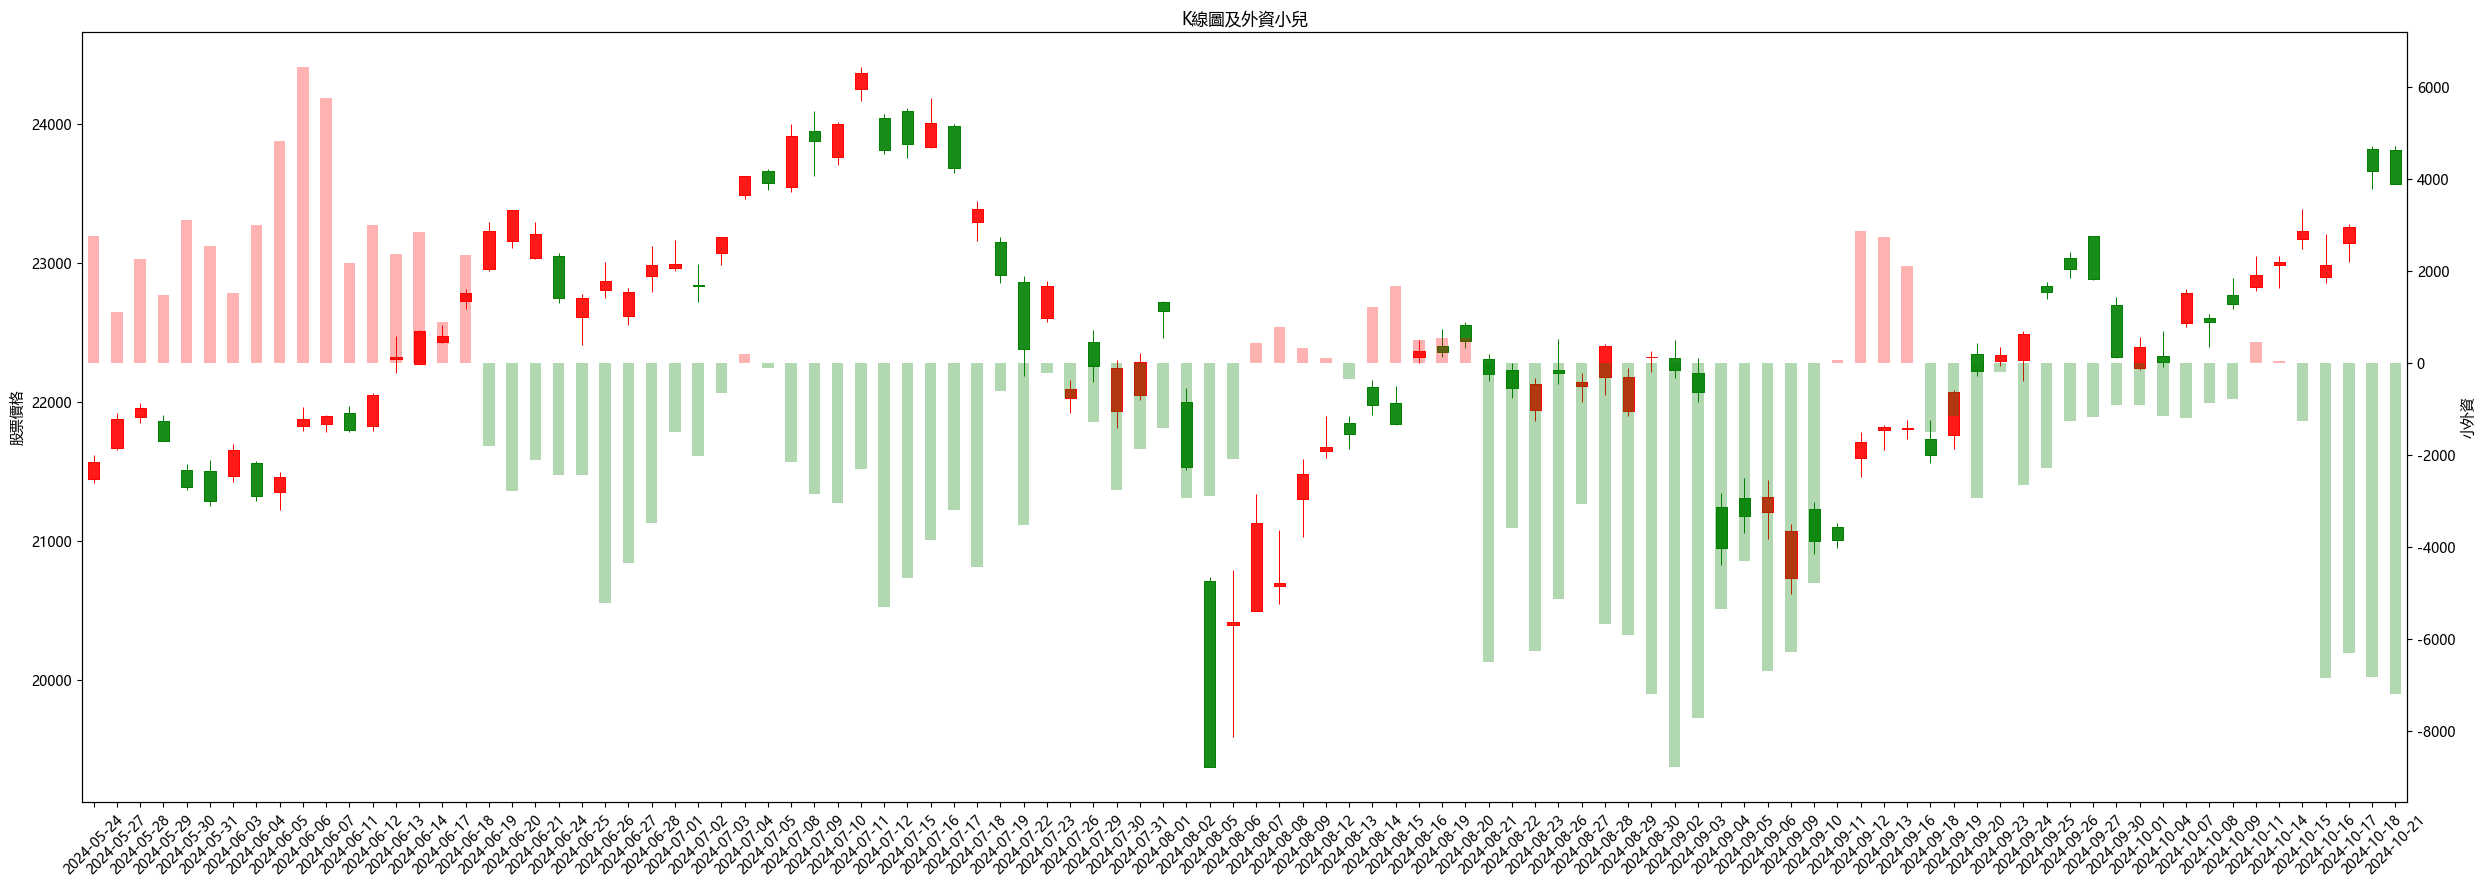

In [12]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


tx_df_raw_100 = tx_df_forplot.tail(plot_size)
tif_investors_df_raw_100 = tif_investors_forplot.tail(plot_size)
tif_investors_df_raw_100.index = tif_investors_df_raw_100.index.strftime('%Y-%m-%d')

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設你的 dataframe 含有必要的 OHLC 數據 (Open, High, Low, Close)
ohlc_data = tx_df_raw_100[['Open', 'High', 'Low', 'Close']]

# 自定義顏色樣式，上漲為紅色，下跌為綠色
my_color = mpf.make_marketcolors(up='red', down='green', edge='inherit', wick='inherit', volume='inherit')

# 自定義樣式
my_style = mpf.make_mpf_style(marketcolors=my_color)

# 設置主圖和次圖
fig, ax1 = plt.subplots(figsize=(30,10))

# 繪製蠟燭圖到 ax1，使用自定義的顏色樣式
mpf.plot(ohlc_data, type='candle', ax=ax1, volume=False, style=my_style)

# 設定 x 軸只顯示日期
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 格式化日期顯示
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自動設置日期間隔

# 旋轉 x 軸標籤以便更清楚顯示
plt.xticks(rotation=45)

# 創建一個共享 X 軸但有不同 Y 軸的次圖 ax2
ax2 = ax1.twinx()

# 繪製小外資的正負長條圖到 ax2
tif_investors_df_raw_100['小外資'].plot(kind='bar', 
                                       color=['red' if v >= 0 else 'green' for v in tif_investors_df_raw_100['小外資']],
                                       ax=ax2, alpha=0.3)  # 調整透明度以顯示蠟燭圖

ax1.set_xticks(ax1.get_xticks()[::1])  # 每隔5个标签显示一个

# 繪製 10MA 移動平均線到 ax1
#ax1.plot(tx_df_raw['10MA'].index, tx_df_raw['10MA'], label='10MA', color='blue', linewidth=2)

# 設定標題和軸標籤
plt.title('K線圖及外資小兒')
ax1.set_ylabel('股票價格')
ax2.set_ylabel('小外資')

# 顯示圖表
plt.show()


In [ ]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 假設你的 dataframe 含有必要的 OHLC 數據 (Open, High, Low, Close)
ohlc_data = tx_df_raw_100[['Open', 'High', 'Low', 'Close']]

# 自定義顏色樣式，上漲為紅色，下跌為綠色
my_color = mpf.make_marketcolors(up='red', down='green', edge='inherit', wick='inherit', volume='inherit')

# 自定義樣式
my_style = mpf.make_mpf_style(marketcolors=my_color)
my_addplot_ma = mpf.make_addplot(tx_df_raw_100['10MA'], color='blue')

# 創建長條圖的附加圖
my_addplot_investors = mpf.make_addplot(tif_investors_df_raw_100['小外資'], 
                                         type='bar', 
                                         color=['red' if v >= 0 else 'green' for v in tif_investors_df_raw_100['小外資']],
                                         alpha=0.3)

# 繪製蠟燭圖並添加 10MA 和小外資長條圖
mpf.plot(ohlc_data, 
         type='candle', 
         style=my_style, 
         addplot=[my_addplot_ma, my_addplot_investors],
         volume=False,
         title='股票蠟燭圖及小外資與10MA',
         ylabel='股票價格 (Open, High, Low, Close)',
         ylabel_lower='小外資',
         figratio=(20, 20), 
         datetime_format='%Y-%m-%d',
         xrotation=45)

# 顯示圖表
plt.show()


📌訊號：小外資由空翻多，或由多翻空

📌進場：等待加權站上或跌破10日均線，日盤尾盤進場，與小外資同向

📌反向則不進場：例如如小外資是空單，加權站上10均，不進場空手觀望

📌主觀認為進入盤整段也不會進場，或是縮小部位以免雙巴到懷疑人生

📌加碼：
跌破/站上10均後反彈至10均或5均，加碼

📌出場策略：
多方：加權跌破10均出場
空方：盤面恐慌急殺時出場


In [23]:
import numpy as np
import warnings
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 隔天開盤直接賣
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()


# 做多=========================================================

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')
merged_df['hold'] = np.nan




# 條件單在這邊下

condition_buy = (merged_df['小外資'] >= 0)

condition_sell = (merged_df['小外資'] < 0)

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()[:-1] # 排除今天
earm_data2_buy = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天

                #小外資大於0 隔天買
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #小外資小於0 隔天賣

                if(len(merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]) > 0):

                        neg_day = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 

                        sell_open = merged_df[(merged_df['Date'] > neg_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0] 
                        sell_date = merged_df[(merged_df['Date'] > neg_day.strftime('%Y-%m-%d'))]['Date'].iloc[0] 
                        sell_date = pd.to_datetime(sell_date)

                        earn = sell_open - buy_open

                        result_df = pd.DataFrame({
                                'buy_date': [buy_date],
                                'sell_date': [sell_date],
                                'buy_open': [buy_open],
                                'sell_open': [sell_open],
                                'earn': [earn]
                                })

                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                earm_data2_buy = pd.concat([earm_data2_buy, result_df], ignore_index=True)
                else:
                        continue

# 做空=========================================================
# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

# 條件單在這邊下 做空

condition_buy = (merged_df['小外資'] < 0)
condition_sell = (merged_df['小外資'] >= 0)

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()[:-1] # 排除今天
earm_data2_sell = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天

                #小外資大於0 隔天買
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #小外資小於0 隔天賣

                if(len(merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]) > 0):

                        neg_day = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 

                        sell_open = merged_df[(merged_df['Date'] > neg_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0] 
                        sell_date = merged_df[(merged_df['Date'] > neg_day.strftime('%Y-%m-%d'))]['Date'].iloc[0] 
                        sell_date = pd.to_datetime(sell_date)

                        earn = buy_open - sell_open

                        result_df = pd.DataFrame({
                                'buy_date': [buy_date],
                                'sell_date': [sell_date],
                                'buy_open': [buy_open],
                                'sell_open': [sell_open],
                                'earn': [earn]
                                })

                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                earm_data2_sell = pd.concat([earm_data2_sell, result_df], ignore_index=True)
                else:
                        continue


earm_data2_bs1 = pd.concat([earm_data2_buy, earm_data2_sell],axis=0, ignore_index=True).sort_values(by='buy_date')
earm_data2_bs1['earncumsum'] = earm_data2_bs1['earn'].cumsum()
#earm_data2_bs[(earm_data2_bs['today_str'] >= '2024-06-01') & (earm_data2_bs['today_str'] <= '2024-12-01')]

earm_data2_bs1 = earm_data2_bs1.sort_values(by='buy_date')

In [ ]:
import numpy as np
import warnings
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 隔天開盤直接賣
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

# 條件單在這邊下 做空

condition_buy = (merged_df['小外資'] < 0)
condition_sell = (merged_df['小外資'] >= 0)

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()[:-1] # 排除今天
earm_data2_sell = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天

                #小外資大於0 隔天買
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #小外資小於0 隔天賣

                if(len(merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]) > 0):

                        neg_day = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 

                        sell_open = merged_df[(merged_df['Date'] > neg_day.strftime('%Y-%m-%d'))]['開盤價'].iloc[0] 
                        sell_date = merged_df[(merged_df['Date'] > neg_day.strftime('%Y-%m-%d'))]['Date'].iloc[0] 
                        sell_date = pd.to_datetime(sell_date)

                        earn = buy_open - sell_open

                        result_df = pd.DataFrame({
                                'buy_date': [buy_date],
                                'sell_date': [sell_date],
                                'buy_open': [buy_open],
                                'sell_open': [sell_open],
                                'earn': [earn]
                                })

                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                earm_data2_sell = pd.concat([earm_data2_sell, result_df], ignore_index=True)
                else:
                        continue


earm_data2_bs1 = pd.concat([earm_data2_buy, earm_data2_sell],axis=0, ignore_index=True).sort_values(by='buy_date')
earm_data2_bs1['earncumsum'] = earm_data2_bs1['earn'].cumsum()
#earm_data2_bs[(earm_data2_bs['today_str'] >= '2024-06-01') & (earm_data2_bs['today_str'] <= '2024-12-01')]

earm_data2_bs1

In [24]:
earm_data2_bs1

,buy_date,sell_date,buy_open,sell_open,earn,earncumsum
37,2021-09-22,2022-07-05,16835.0,14350.0,2485.0,2485.0
0,2022-07-05,2022-07-07,14350.0,14068.0,-282.0,2203.0
38,2022-07-07,2022-07-08,14068.0,14390.0,-322.0,1881.0
1,2022-07-12,2022-08-17,14157.0,15404.0,1247.0,3128.0
39,2022-08-17,2022-08-31,15404.0,14849.0,555.0,3683.0
...,...,...,...,...,...,...
34,2024-08-16,2024-08-22,22324.0,22229.0,-95.0,12561.0
69,2024-08-22,2024-09-12,22229.0,21597.0,632.0,13193.0
35,2024-09-12,2024-09-19,21597.0,21763.0,166.0,13359.0
70,2024-09-19,2024-10-14,21763.0,22987.0,-1224.0,12135.0


In [ ]:
merged_df[['Date', '開盤價' ,'最後成交價','小外資','小外資變化' ,'10MA','hold']].tail(30)

===大盤累積====
6086.0
===外資小兒法累積====
12045.0
===進出次數====
71
===第一次買進===
2021-09-22 00:00:00
===最後一次賣出===
2024-10-16 00:00:00


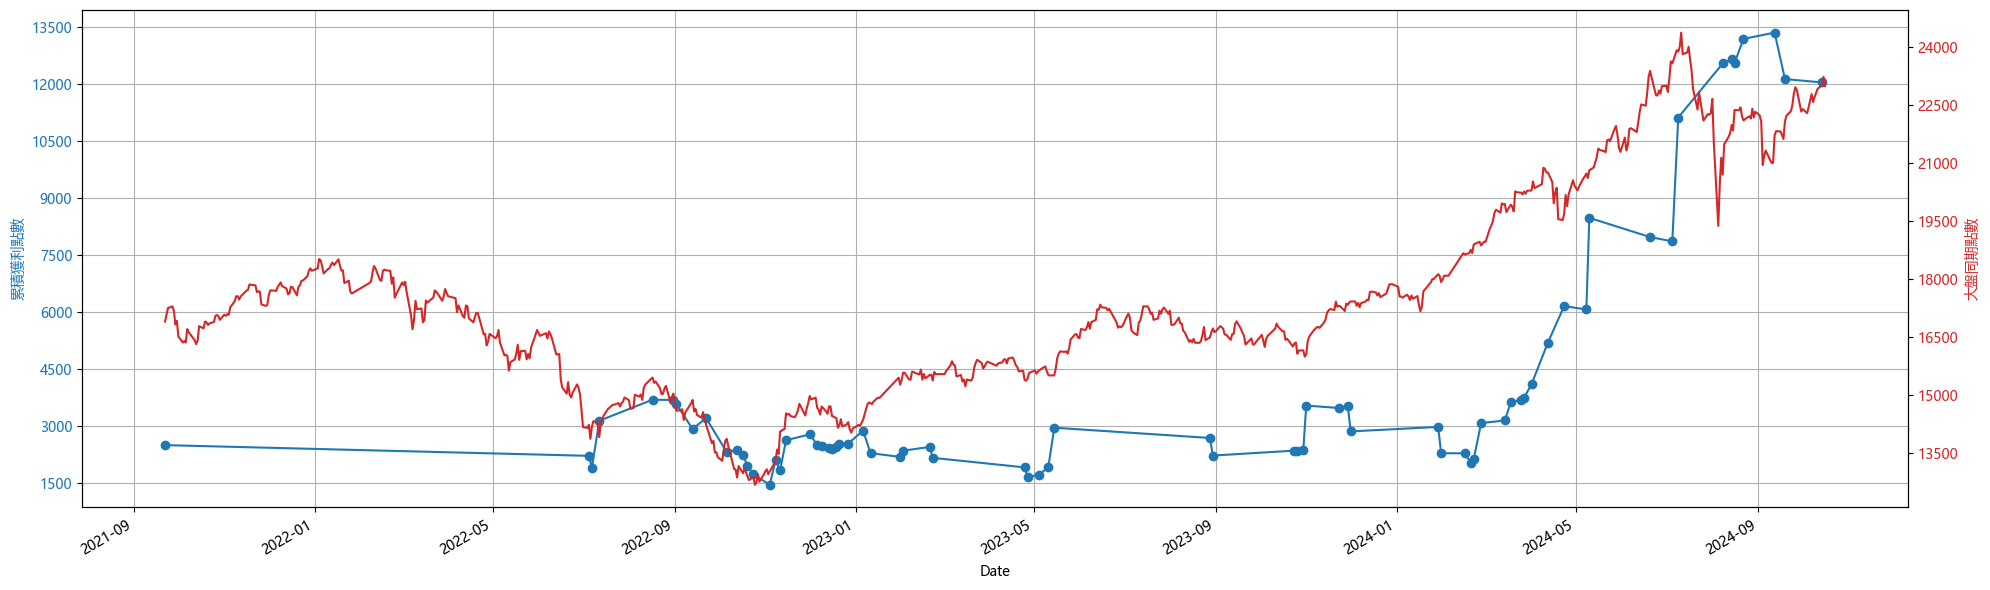

In [30]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  earm_data2_bs1['buy_date'].iloc[0]) & (merged_df['Date'] <= earm_data2_bs1['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(earm_data2_bs1['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(earm_data2_bs1))

print('===第一次買進===')
print(earm_data2_bs1['buy_date'].iloc[0])

print('===最後一次賣出===')
print(earm_data2_bs1['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(earm_data2_bs1['buy_date'], earm_data2_bs1['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


In [87]:
import numpy as np
import warnings
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 隔天開盤直接賣
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

# 條件單在這邊下

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資變化'] > 0))

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()[:-1] # 排除今天
earm_data1 = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天

                close = merged_df[merged_df['Date'] > today_str]['最後成交價'].iloc[0] 
                ma10 = merged_df[merged_df['Date'] > today_str][MA].iloc[0] 

                if (close >=  ma10):
                        #隔天收盤要站上再買進
                        buy_close = merged_df[merged_df['Date'] > today_str]['最後成交價'].iloc[0] 
                        buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                        #跌破ma當天

                        if(len(merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]) > 0):
                                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                                sell_date = pd.to_datetime(sell_date)

                                earn = sell_open - buy_close

                                result_df = pd.DataFrame({
                                        'buy_date': [buy_date],
                                        'sell_date': [sell_date],
                                        'buy_open': [buy_close],
                                        'sell_open': [sell_open],
                                        'earn': [earn]
                                        })

                                # 删除全为NA的列，避免可能出现的警告
                                result_df.dropna(axis=1, how='all', inplace=True)

                                if not result_df.empty:
                                        earm_data1 = pd.concat([earm_data1, result_df], ignore_index=True)
                        else:
                                continue

        
# earm_data1['cumsum'] = earm_data1['earn'].cumsum()
# earm_data1



In [ ]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  earm_data1['buy_date'].iloc[0]) & (merged_df['Date'] <= earm_data1['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(earm_data1['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(earm_data1))

print('===第一次買進===')
print(earm_data1['buy_date'].iloc[0])

print('===最後一次賣出===')
print(earm_data1['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(earm_data1['buy_date'], earm_data1['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


In [28]:
# merged_df[(merged_df['Date'] >= '2024-07-01') & (merged_df['Date'] <= '2024-07-10')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]
#merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > '2024-06-28')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]

===大盤累積====
5404.0
===外資小兒法累積====
7610.0
===進出次數====
125
===第一次買進===
2021-09-17 00:00:00
===最後一次賣出===
2024-10-09 00:00:00


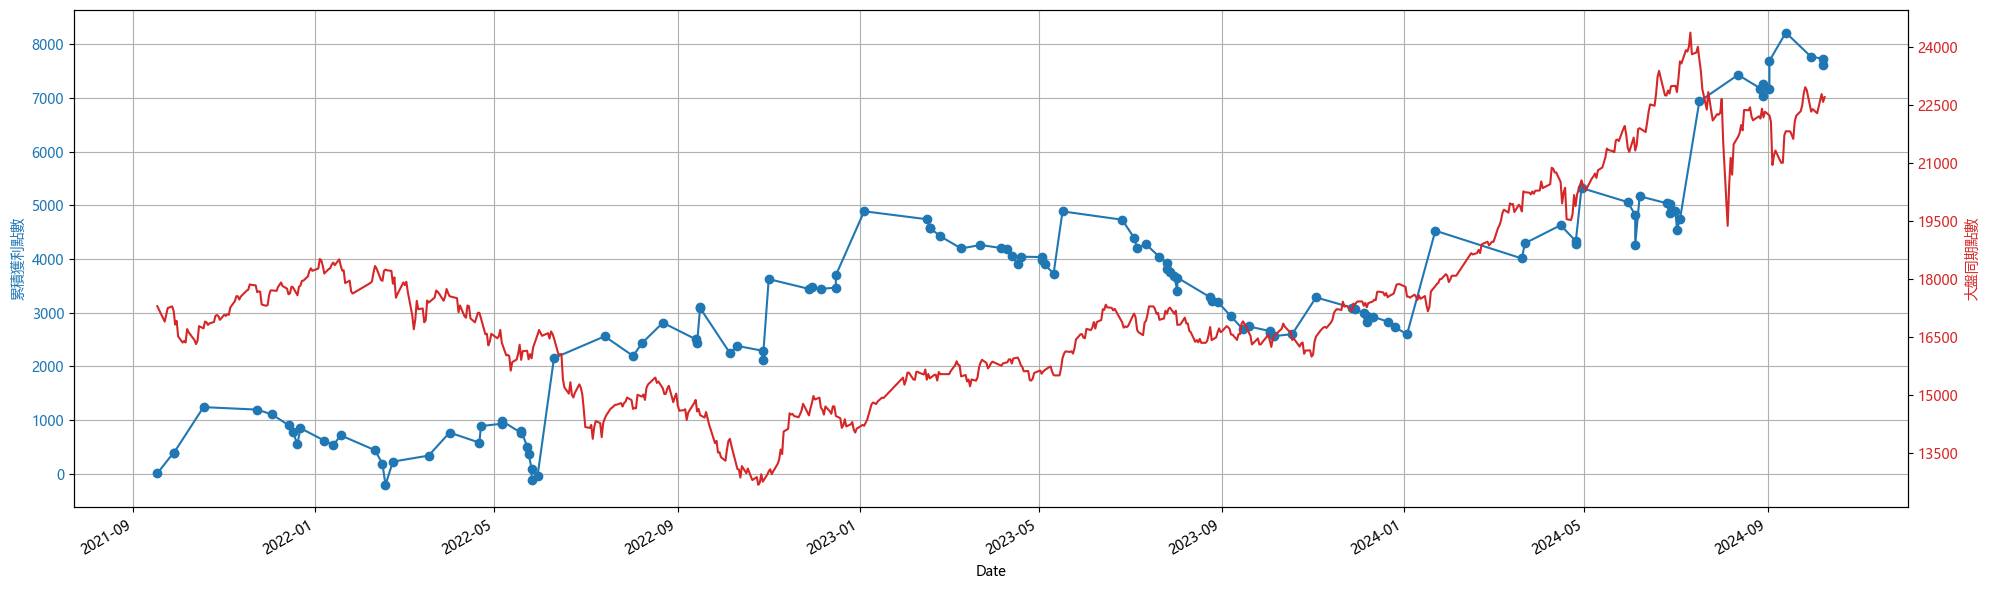

In [37]:
import numpy as np
import warnings
# 如果單純看10MA不管小外資 
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] <  merged_df[MA]))  

condition_sell = (merged_df['最後成交價'] >=  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()[:-1] # 排除今天
earm_data2_sell = pd.DataFrame(columns=['today_str','buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                
                buy_df = merged_df[merged_df['Date'] == today_str]

                if (len(buy_df) > 0):
                        # 收盤跌破十日線直接開空 不囉嗦
                        buy_open = merged_df[merged_df['Date'] == today_str]['最後成交價'].iloc[0] 
                        buy_date = merged_df[merged_df['Date'] == today_str]['Date'].iloc[0] 

                        sell_df = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]
                        
                        if (len(sell_df) >1 ):
                                
                                #跌破ma當天
                                if(len(merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]) > 0):
                                        sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                                        sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                                        sell_date = pd.to_datetime(sell_date)
                                        # 做空倒過來
                                        earn = buy_open - sell_open 

                                        result_df = pd.DataFrame({
                                                'today_str' : [today_str],
                                                'buy_date': [buy_date],
                                                'sell_date': [sell_date],
                                                'buy_open': [buy_open],
                                                'sell_open': [sell_open],
                                                'earn': [earn],
                                                'type' : ['s']
                                                })

                                        # 删除全为NA的列，避免可能出现的警告
                                        result_df.dropna(axis=1, how='all', inplace=True)

                                        if not result_df.empty:
                                                earm_data2_sell = pd.concat([earm_data2_sell, result_df], ignore_index=True)


# 做多 ==========================================================================================================================

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]))

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()[:-1] # 排除今天
earm_data2_buy = pd.DataFrame(columns=['today_str' ,'buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                if(len(merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]) > 0):
                        sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                        sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                        sell_date = pd.to_datetime(sell_date)

                        earn = sell_open - buy_open

                        result_df = pd.DataFrame({
                                'today_str' : [today_str],
                                'buy_date': [buy_date],
                                'sell_date': [sell_date],
                                'buy_open': [buy_open],
                                'sell_open': [sell_open],
                                'earn': [earn],
                                'type': ['b']
                                })

                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                earm_data2_buy = pd.concat([earm_data2_buy, result_df], ignore_index=True)

        
earm_data2_bs1 = pd.concat([earm_data2_buy, earm_data2_sell],axis=0, ignore_index=True).sort_values(by='buy_date')
earm_data2_bs1['earncumsum'] = earm_data2_bs1['earn'].cumsum()
#earm_data2_bs[(earm_data2_bs['today_str'] >= '2024-06-01') & (earm_data2_bs['today_str'] <= '2024-12-01')]

earm_data2_bs1

import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  earm_data2_bs1['buy_date'].iloc[0]) & (merged_df['Date'] <= earm_data2_bs1['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(earm_data2_bs1['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(earm_data2_bs1))

print('===第一次買進===')
print(earm_data2_bs1['buy_date'].iloc[0])

print('===最後一次賣出===')
print(earm_data2_bs1['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(earm_data2_bs1['buy_date'], earm_data2_bs1['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


直接看 大盤十日線 十日以上買 以下賣 做空多看季線 季線以上不做空

===大盤累積====
5405.0
===外資小兒法累積====
9337.0
===進出次數====
91
===第一次買進===
2021-09-28 00:00:00
===最後一次賣出===
2024-10-08 00:00:00


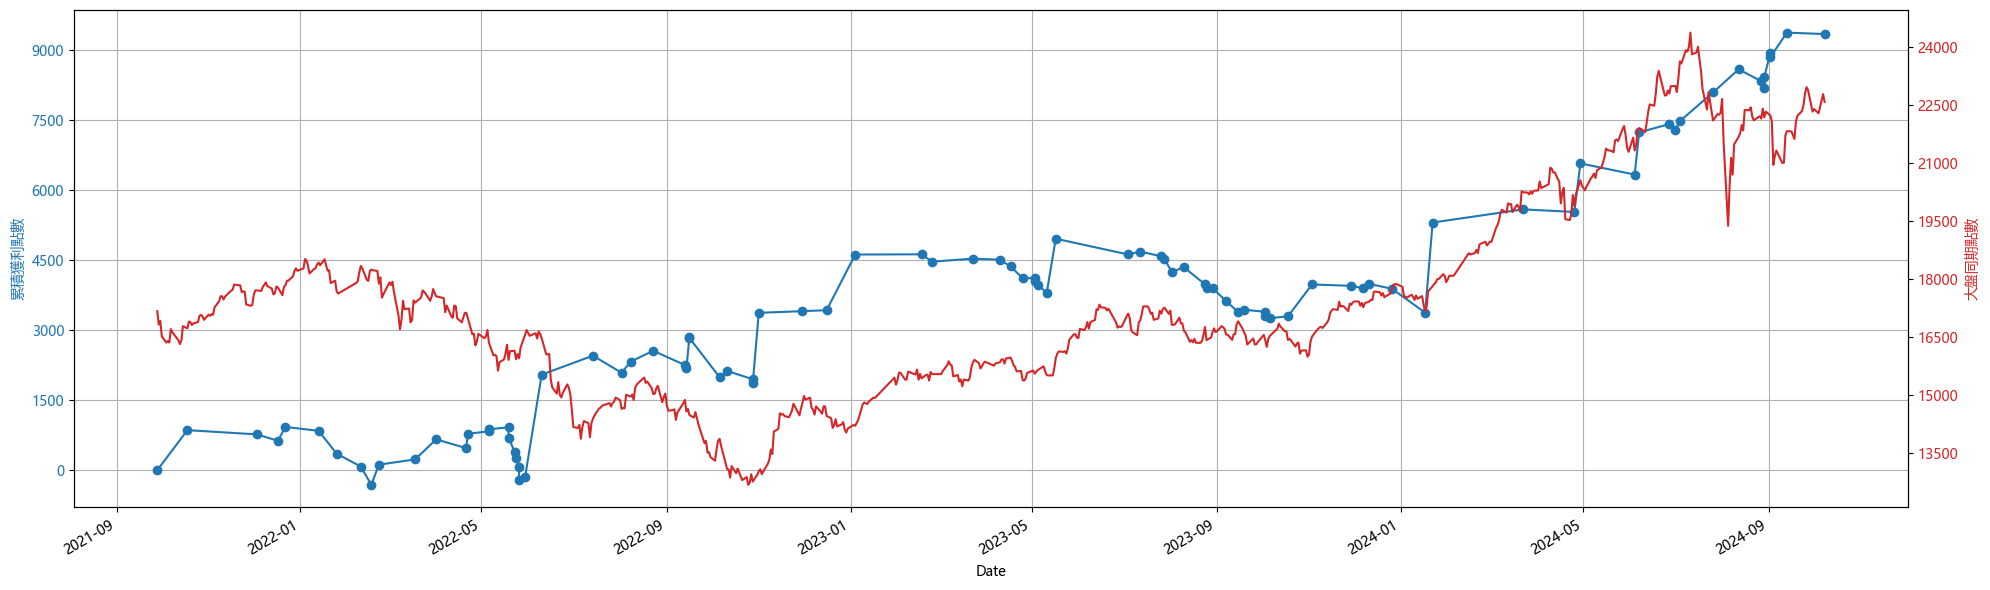

In [40]:
import numpy as np
import warnings
# 如果單純看10MA不管小外資 
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] <=  merged_df[MA]) & (merged_df['最後成交價'] <=  merged_df['60MA']))  # 多加一個季線以下

condition_sell = (merged_df['最後成交價'] >  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()[:-1] # 排除今天
earm_data2_sell = pd.DataFrame(columns=['today_str','buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                
                buy_df = merged_df[merged_df['Date'] == today_str]

                if (len(buy_df) > 0):
                        # 收盤跌破十日線直接開空 不囉嗦
                        buy_open = merged_df[merged_df['Date'] == today_str]['最後成交價'].iloc[0] 
                        buy_date = merged_df[merged_df['Date'] == today_str]['Date'].iloc[0] 

                        sell_df = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]
                        
                        if (len(sell_df) >1 ):
                                
                                #跌破ma當天
                                if(len(merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]) > 0):
                                        sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                                        sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                                        sell_date = pd.to_datetime(sell_date)
                                        # 做空倒過來
                                        earn = buy_open - sell_open 

                                        result_df = pd.DataFrame({
                                                'today_str' : [today_str],
                                                'buy_date': [buy_date],
                                                'sell_date': [sell_date],
                                                'buy_open': [buy_open],
                                                'sell_open': [sell_open],
                                                'earn': [earn],
                                                'type' : ['s']
                                                })

                                        # 删除全为NA的列，避免可能出现的警告
                                        result_df.dropna(axis=1, how='all', inplace=True)

                                        if not result_df.empty:
                                                earm_data2_sell = pd.concat([earm_data2_sell, result_df], ignore_index=True)


# 做多 ==========================================================================================================================

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]))

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()[:-1] # 排除今天
earm_data2_buy = pd.DataFrame(columns=['today_str' ,'buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                if(len(merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]) > 0):
                        sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                        sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                        sell_date = pd.to_datetime(sell_date)

                        earn = sell_open - buy_open

                        result_df = pd.DataFrame({
                                'today_str' : [today_str],
                                'buy_date': [buy_date],
                                'sell_date': [sell_date],
                                'buy_open': [buy_open],
                                'sell_open': [sell_open],
                                'earn': [earn],
                                'type': ['b']
                                })

                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                earm_data2_buy = pd.concat([earm_data2_buy, result_df], ignore_index=True)

        
earm_data2_bs1 = pd.concat([earm_data2_buy, earm_data2_sell],axis=0, ignore_index=True).sort_values(by='buy_date')
earm_data2_bs1['earncumsum'] = earm_data2_bs1['earn'].cumsum()
#earm_data2_bs[(earm_data2_bs['today_str'] >= '2024-06-01') & (earm_data2_bs['today_str'] <= '2024-12-01')]

earm_data2_bs1

import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  earm_data2_bs1['buy_date'].iloc[0]) & (merged_df['Date'] <= earm_data2_bs1['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(earm_data2_bs1['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(earm_data2_bs1))

print('===第一次買進===')
print(earm_data2_bs1['buy_date'].iloc[0])

print('===最後一次賣出===')
print(earm_data2_bs1['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(earm_data2_bs1['buy_date'], earm_data2_bs1['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


In [ ]:
merged_df[(merged_df['Date'] >= '2024-08-01') & (merged_df['Date'] <= '2024-10-01')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]

回測指數進出

加入小外資當作多空訊號

===大盤累積====
4648.0
===外資小兒法累積====
13053.0
===進出次數====
25
===第一次買進===
2022-01-25 00:00:00
===最後一次賣出===
2024-09-30 00:00:00


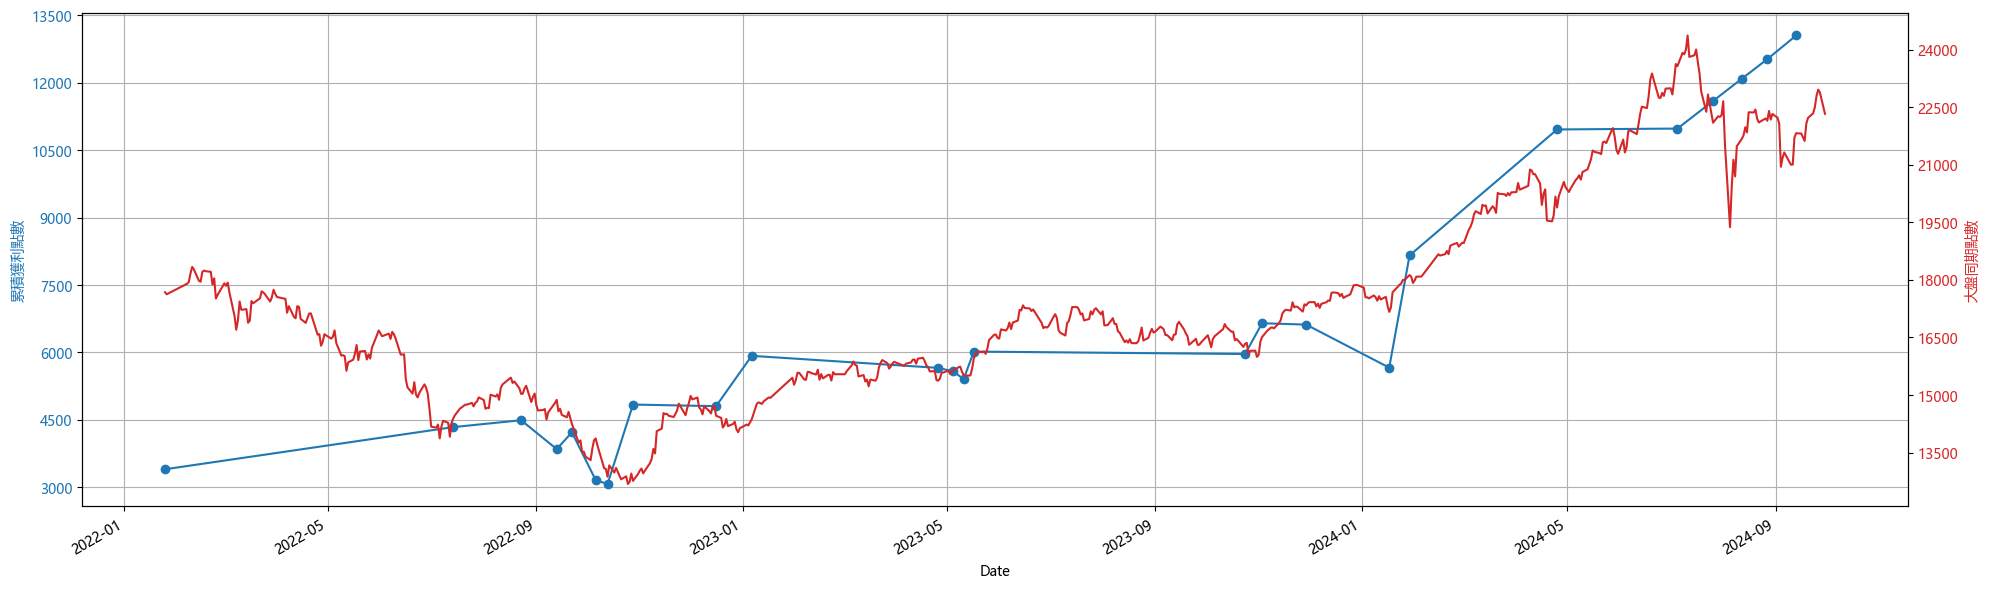

In [90]:
import numpy as np
import warnings
# 改成做空

# 計算訊號出來後隔天開盤直接空爆
# 出場訊號出來後 收盤直接補
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df1 = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df1['hold'] = np.nan

condition_buy = ((merged_df1['最後成交價'] <=  merged_df1[MA]) & (merged_df1['小外資'] < 0) & (merged_df1['最後成交價'] <=  merged_df1['60MA']))  # 多加一個季線以下

condition_sell = ((merged_df1['最後成交價'] >  merged_df1[MA]) & (merged_df1['小外資'].shift(1) >= 0))

merged_df1.loc[condition_buy, 'hold'] = 1
merged_df1.loc[condition_sell, 'hold'] = 0

merged_df1['hold'].ffill(inplace=True)
merged_df1['hold'] = merged_df1['hold'].fillna(0)

# 計算進出

day_list = merged_df1['Date'].unique().tolist()[:-1] # 排除今天
earm_data2_sell = pd.DataFrame(columns=['today_str','buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df1[merged_df1['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                
                buy_df = merged_df1[merged_df1['Date'] > today_str]

                if (len(buy_df) > 0):
                        #隔天開盤價買進
                        # buy_open = merged_df1[merged_df1['Date'] == today_str]['最後成交價'].iloc[0] 
                        buy_open = merged_df1[merged_df1['Date'] > today_str]['開盤價'].iloc[0] 
                        buy_date = merged_df1[merged_df1['Date'] >  today_str]['Date'].iloc[0] 

                        sell_df = merged_df1[(merged_df1['hold'] == 0) & (merged_df1['Date'] > today_str)]
                        
                        if (len(sell_df) >1 ):
                                
                                #跌破ma當天
                                if(len(merged_df1[(merged_df1['hold'] == 0) & (merged_df1['Date'] > today_str)]) > 0):
                                        # select_day = merged_df1[(merged_df1['hold'] == 0) & (merged_df1['Date'] > today_str)]['Date'].iloc[0] 
                                        # sell_open = merged_df1[(merged_df1['Date'] > select_day)]['開盤價'].iloc[0] 
                                        # sell_date = merged_df1[(merged_df1['Date'] > select_day)]['Date'].iloc[0]  
                                        sell_open = merged_df1[(merged_df1['hold'] == 0) & (merged_df1['Date'] > today_str)]['最後成交價'].iloc[0] 
                                        sell_date = merged_df1[(merged_df1['hold'] == 0) & (merged_df1['Date'] > today_str)]['Date'].iloc[0] 
                                        sell_date = pd.to_datetime(sell_date)

                                        earn = buy_open - sell_open 

                                        result_df = pd.DataFrame({
                                                'today_str' : [today_str],
                                                'buy_date': [buy_date],
                                                'sell_date': [sell_date],
                                                'buy_open': [buy_open],
                                                'sell_open': [sell_open],
                                                'earn': [earn],
                                                'type' : ['s']
                                                })

                                        # 删除全为NA的列，避免可能出现的警告
                                        result_df.dropna(axis=1, how='all', inplace=True)

                                        if not result_df.empty:
                                                earm_data2_sell = pd.concat([earm_data2_sell, result_df], ignore_index=True)


# =================================================================================================================================================

# 做多
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 收盤直接賣出

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資'] > 0) )

condition_sell = ((merged_df['最後成交價'] <  merged_df[MA]) & (merged_df['小外資'].shift(1) < 0))

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()[:-1] # 排除今天
earm_data2_buy = pd.DataFrame(columns=['today_str' ,'buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                if(len(merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]) > 0):
                        # select_day = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                        # sell_open = merged_df[(merged_df['Date'] > select_day)]['開盤價'].iloc[0] 
                        # sell_date = merged_df[(merged_df['Date'] > select_day)]['Date'].iloc[0]  
                        sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                        sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                        sell_date = pd.to_datetime(sell_date)

                        earn = sell_open - buy_open

                        result_df = pd.DataFrame({
                                'today_str' : [today_str],
                                'buy_date': [buy_date],
                                'sell_date': [sell_date],
                                'buy_open': [buy_open],
                                'sell_open': [sell_open],
                                'earn': [earn],
                                'type': ['b']
                                })

                        # 删除全为NA的列，避免可能出现的警告
                        result_df.dropna(axis=1, how='all', inplace=True)

                        if not result_df.empty:
                                earm_data2_buy = pd.concat([earm_data2_buy, result_df], ignore_index=True)

        
# earm_data2_buy['earncumsum'] = earm_data2_buy['earn'].cumsum()
# earm_data2_buy

earm_data2_bs2 = pd.concat([earm_data2_buy, earm_data2_sell],axis=0, ignore_index=True).sort_values(by='buy_date')
earm_data2_bs2['earncumsum'] = earm_data2_bs2['earn'].cumsum()
# earm_data2_bs2

import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  earm_data2_bs2['buy_date'].iloc[0]) & (merged_df['Date'] <= earm_data2_bs2['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(earm_data2_bs2['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(earm_data2_bs2))

print('===第一次買進===')
print(earm_data2_bs2['buy_date'].iloc[0])

print('===最後一次賣出===')
print(earm_data2_bs2['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(earm_data2_bs2['buy_date'], earm_data2_bs2['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


In [87]:
earm_data2_bs2

,today_str,buy_date,sell_date,buy_open,sell_open,earn,type,earncumsum
15,2022-01-25,2022-01-26,2022-07-13,17683.0,14277.0,3406.0,s,3406.0
0,2022-07-13,2022-07-14,2022-08-22,14237.0,15175.0,938.0,b,4344.0
16,2022-08-23,2022-08-24,2022-09-13,15080.0,14875.0,205.0,s,4549.0
1,2022-09-12,2022-09-13,2022-09-22,14884.0,14242.0,-642.0,b,3907.0
17,2022-09-21,2022-09-22,2022-10-06,14225.0,13869.0,356.0,s,4263.0
2,2022-10-05,2022-10-06,2022-10-13,13932.0,12869.0,-1063.0,b,3200.0
18,2022-10-12,2022-10-13,2022-10-27,13032.0,12956.0,76.0,s,3276.0
3,2022-10-27,2022-10-28,2022-12-07,12855.0,14623.0,1768.0,b,5044.0
4,2022-12-15,2022-12-16,2022-12-19,14440.0,14404.0,-36.0,b,5008.0
5,2023-01-05,2023-01-06,2023-02-15,14278.0,15398.0,1120.0,b,6128.0


In [85]:
tt = merged_df1[(merged_df1['最後成交價'] < merged_df1['60MA']) & (merged_df1['小外資變化'] <- 5000)]
tt[['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','60MA','hold']].sort_values(by='小外資變化' , ascending=True).tail(20)


tt = merged_df1[(merged_df1['Date'] >= '2022-08-20') & (merged_df1['Date'] <= '2022-10-20')][['Date', '開盤價' ,'最後成交價','小外資' ,'10MA','60MA','hold']]

tt['10B'] = tt['最後成交價'] > tt['10MA']
tt['60B']  = tt['最後成交價'] > tt['60MA']
tt

,Date,開盤價,最後成交價,小外資,10MA,60MA,hold,10B,60B
225,2022-08-22,15171.0,15175.0,-3254.0,15245.1,15142.333333,0.0,False,True
226,2022-08-23,15059.0,15028.0,-3896.0,15246.3,15116.800000,1.0,False,False
227,2022-08-24,15080.0,15035.0,-5484.0,15262.2,15089.350000,1.0,False,False
228,2022-08-25,15130.0,15172.0,-5574.0,15261.1,15065.383333,1.0,False,True
229,2022-08-26,15271.0,15241.0,-1859.0,15258.0,15043.866667,1.0,False,True
230,2022-08-29,14832.0,14818.0,-750.0,15201.1,15014.166667,1.0,False,False
231,2022-08-30,14850.0,14948.0,187.0,15153.7,14988.933333,1.0,False,False
232,2022-08-31,14849.0,15039.0,-11135.0,15112.4,14962.183333,1.0,False,True
233,2022-09-01,14841.0,14736.0,-9346.0,15054.5,14931.416667,1.0,False,False
234,2022-09-02,14776.0,14597.0,-14313.0,14978.9,14900.183333,1.0,False,False


In [53]:
import numpy as np
import warnings
# 計算訊號出來後隔天開盤直接買
# 出場訊號出來後 收盤直接賣出
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]
tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)
tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資變化'] > 0) )

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data2_buy = pd.DataFrame(columns=['today_str' ,'buy_date','sell_date','buy_open','sell_open','earn','type'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)

                earn = sell_open - buy_open

                result_df = pd.DataFrame({
                        'today_str' : [today_str],
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_open],
                        'sell_open': [sell_open],
                        'earn': [earn],
                        'type': ['b']
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data2_buy = pd.concat([earm_data2_buy, result_df], ignore_index=True)

        
# earm_data2_buy['earncumsum'] = earm_data2_buy['earn'].cumsum()
# earm_data2_buy


In [212]:
# earm_data2
# merged_df[(merged_df['Date'] >= '2024-06-01') & (merged_df['Date'] <= '2024-08-01')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]
# #merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > '2024-06-28')][['Date', '開盤價' ,'最後成交價','小外資變化' ,'10MA','hold']]

畫圖 可以直接用 print_data = 想畫的圖就行了

===大盤累積====
5421.0
===外資小兒法累積====
7551.0
===進出次數====
71
===第一次買進===
2021-10-18 00:00:00
===最後一次賣出===
2024-08-27 00:00:00


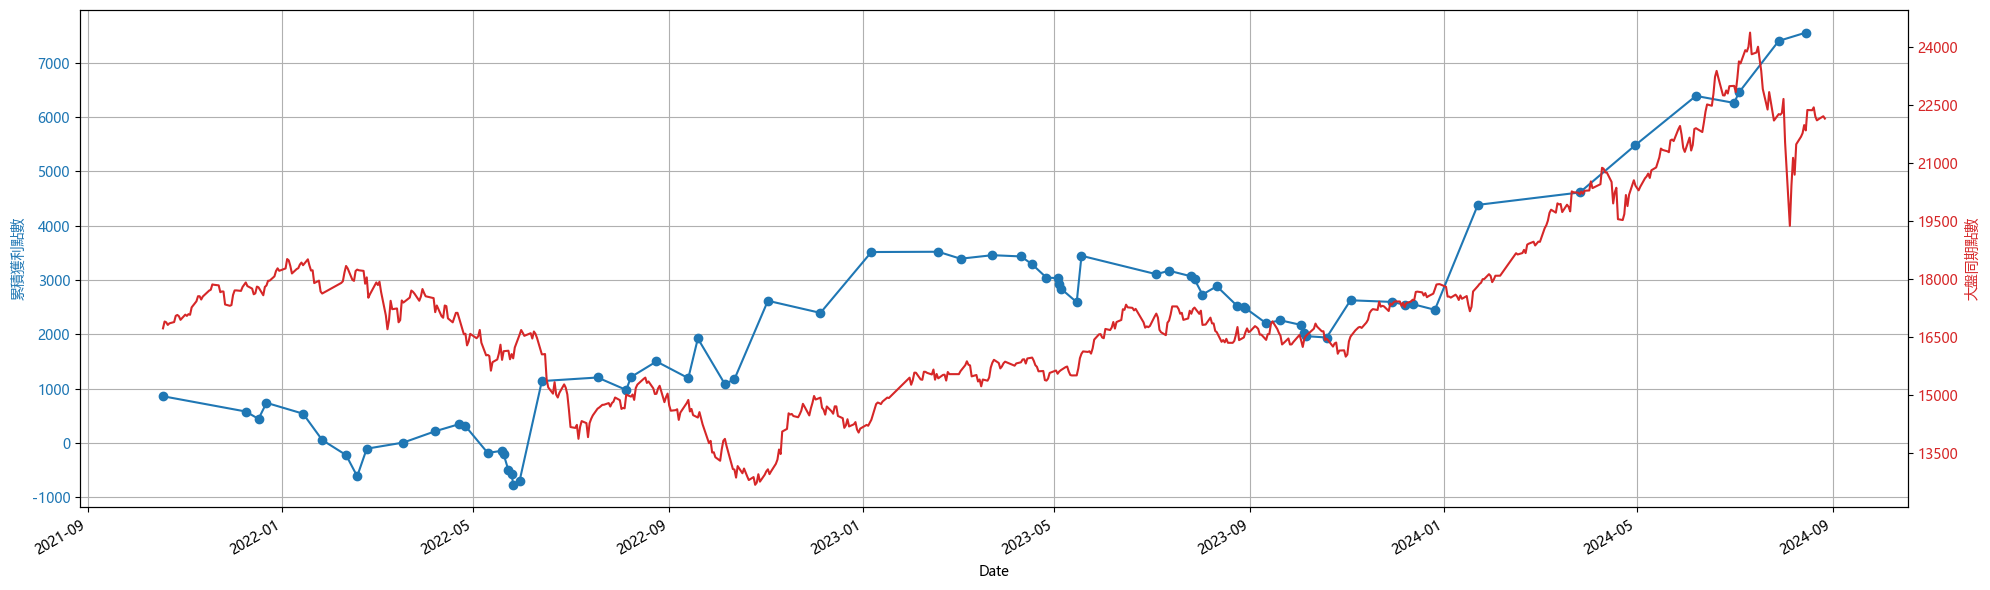

In [86]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

print_data = earm_data2_bs2

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  print_data['buy_date'].iloc[0]) & (merged_df['Date'] <= print_data['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(print_data['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(print_data))

print('===第一次買進===')
print(print_data['buy_date'].iloc[0])

print('===最後一次賣出===')
print(print_data['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(print_data['buy_date'], print_data['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()


In [87]:

# test = merged_df[merged_df['Date'].isin(earm_data1['buy_date'])][['Date', '開盤價' ,'最後成交價' ,'10MA','20MA']]

# test['開10'] = test['開盤價'] - test['10MA']
# test['收10'] = test['最後成交價'] - test['10MA']
# test


In [205]:
import numpy as np
import warnings
# 計算訊號出來 外資小兒翻多單
# 出場訊號出來後 隔天開盤直接賣
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

MA = '10MA'

tx_df_raw = tx_df_raw[tx_df_raw[MA] != 0]
# tx_df_raw[tx_df_raw['最後成交價'] >= tx_df_raw['10MA']]

# tif_investors_df_raw['小外資變化'] = tif_investors_df_raw['小外資'].diff(1)

tif_investors_df_raw.dropna()

# 使用 'Date' 欄位進行內部連接
merged_df = pd.merge(tif_investors_df_raw, tx_df_raw, on='Date', how='inner')

merged_df['hold'] = np.nan

# 改成小外資多單的話進場
condition_buy = ((merged_df['最後成交價'] >=  merged_df[MA]) & (merged_df['小外資'] > 0))

condition_sell = (merged_df['最後成交價'] <  merged_df[MA])

merged_df.loc[condition_buy, 'hold'] = 1
merged_df.loc[condition_sell, 'hold'] = 0

merged_df['hold'].ffill(inplace=True)
merged_df['hold'] = merged_df['hold'].fillna(0)

# 計算進出

day_list = merged_df['Date'].unique().tolist()
earm_data3 = pd.DataFrame(columns=['buy_date','sell_date','buy_open','sell_open','earn'])

sell_date = pd.to_datetime("1911-01-01")  # Example Timestamp

for day in day_list:
        today_str = day.strftime('%Y-%m-%d')
        stock_df_today = merged_df[merged_df['Date'] == today_str].copy() 

        if((stock_df_today['hold'].iloc[0] == 1) & ( pd.to_datetime(today_str) > sell_date)): # 符合條件第一天
                #隔天開盤價買進
                buy_open = merged_df[merged_df['Date'] > today_str]['開盤價'].iloc[0] 
                buy_date = merged_df[merged_df['Date'] > today_str]['Date'].iloc[0] 


                #跌破ma當天
                sell_open = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['最後成交價'].iloc[0] 
                sell_date = merged_df[(merged_df['hold'] == 0) & (merged_df['Date'] > today_str)]['Date'].iloc[0] 
                sell_date = pd.to_datetime(sell_date)

                earn = sell_open - buy_open

                result_df = pd.DataFrame({
                        'buy_date': [buy_date],
                        'sell_date': [sell_date],
                        'buy_open': [buy_open],
                        'sell_open': [sell_open],
                        'earn': [earn]
                        })

                # 删除全为NA的列，避免可能出现的警告
                result_df.dropna(axis=1, how='all', inplace=True)

                if not result_df.empty:
                        earm_data3 = pd.concat([earm_data3, result_df], ignore_index=True)

        


In [208]:
earm_data3['earncumsum'] = earm_data3['earn'].cumsum()
earm_data3

,buy_date,sell_date,buy_open,sell_open,earn,earncumsum
0,2022-07-14,2022-08-02,14237.0,14643.0,406.0,406.0
1,2022-08-08,2022-08-22,14937.0,15175.0,238.0,644.0
2,2022-09-13,2022-09-14,14884.0,14577.0,-307.0,337.0
3,2022-09-16,2022-09-16,14500.0,14483.0,-17.0,320.0
4,2022-10-06,2022-10-11,13932.0,13091.0,-841.0,-521.0
5,2022-10-28,2022-10-28,12855.0,12764.0,-91.0,-612.0
6,2022-11-01,2022-11-28,12960.0,14475.0,1515.0,903.0
7,2022-11-30,2022-12-06,14640.0,14675.0,35.0,938.0
8,2022-12-16,2022-12-16,14440.0,14461.0,21.0,959.0
9,2023-01-06,2023-02-15,14278.0,15398.0,1120.0,2079.0


===大盤累積====
7757.0
===外資小兒法累積====
6370.0
===進出次數====
32
===第一次買進===
2022-07-14 00:00:00
===最後一次賣出===
2024-08-27 00:00:00


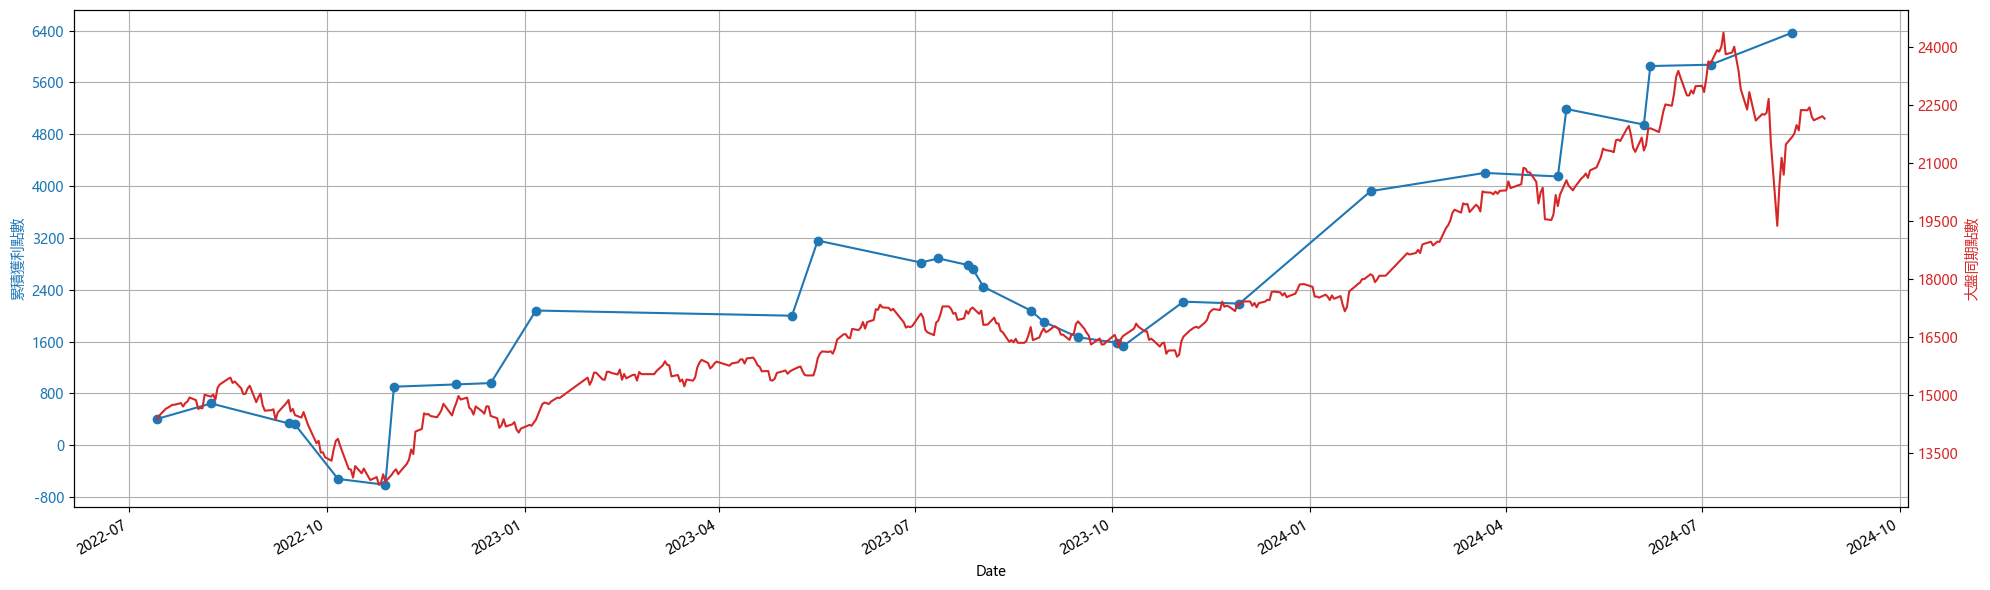

In [207]:
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.ticker import MaxNLocator

# 同期大盤資料 
tx_df = merged_df[( merged_df['Date'] >=  earm_data3['buy_date'].iloc[0]) & (merged_df['Date'] <= earm_data3['sell_date'].iloc[-1])]

print('===大盤累積====')
print(tx_df['最後成交價'].iloc[-1] - tx_df['最後成交價'].iloc[0])

print('===外資小兒法累積====')
print(earm_data3['earn'].cumsum().iloc[-1])

print('===進出次數====')
print(len(earm_data3))

print('===第一次買進===')
print(earm_data3['buy_date'].iloc[0])

print('===最後一次賣出===')
print(earm_data3['sell_date'].iloc[-1])

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 假設 'Date' 已經是日期格式
fig, ax1 = plt.subplots(figsize=(20, 6))

# 第一條線 - 最後成交價
ax1.set_xlabel('Date')
ax1.set_ylabel('累積獲利點數', color='tab:blue')
ax1.plot(earm_data3['buy_date'], earm_data3['earn'].cumsum(), color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 開啟網格
ax1.grid(True)
# 調整 Y 軸間距 (設定更多標籤)
ax1.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 建立第二個Y軸
ax2 = ax1.twinx()  
ax2.set_ylabel('大盤同期點數', color='tab:red')  # 可以根據需要調整標籤
ax2.plot(tx_df['Date'], tx_df['最後成交價'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 調整第二個 Y 軸間距 (同樣設定更多標籤)
ax2.yaxis.set_major_locator(MaxNLocator(prune=None, nbins=10))  # 增加 Y 軸標籤數量

# 旋轉日期標籤
fig.autofmt_xdate()

# 顯示圖表
fig.tight_layout()
plt.show()
